In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Outputs will be saved in your google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# file input and output paths

input_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/Python preprocessed/'
output_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/2_Stationary/'

In [ ]:
# retrieve data
def get_data(variable, path_in = input_path):
    input_file = path_in + variable +'.csv'
    data = pd.read_csv(input_file, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.astype(float)
    data = data.sort_index()
    return data

In [ ]:
financial_variables = ['oil', 'silver', 'eurusd', 'eurcfh', 'spx']
macro_variables = ['inflation', 'unemployment', 'imports', 'exports', 'bond_yield', 'exchange', 'ppi', 'bci', 'cci', 'construction', 'manufacturing', 'world', 'share_prices']
all_variables = macro_variables + financial_variables

countries = ['Belgium', 'Denmark', 'Germany', 'Spain', 'France', 'Italy', 'Netherlands', 'Austria', 'Poland', 'Finland', 'Sweden', 'United States']

In [ ]:
year_locator = mdates.MonthLocator(interval=12)
year_formatter = mdates.DateFormatter("%Y")

# Figures for Stationary

### Inflation (Germany)

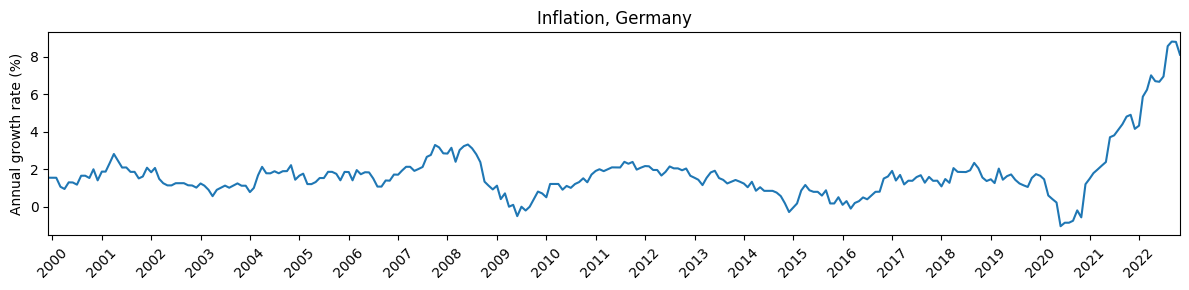

In [ ]:
data = get_data('inflation')['Germany']

fig, ax = plt.subplots(1,1)
ax.plot(data)
ax.set_title("Inflation, Germany")
ax.set_ylabel("Annual growth rate (%)")
data.index[0]
ax.set_xlim(data.index[0], data.index[len(data)-1])
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(year_formatter) # formatter for major axis only
ax.tick_params(axis='x', labelrotation=45)
fig.set_size_inches(12,3)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Gradu/Figures/inflation_germany.png')

### World trade volumes

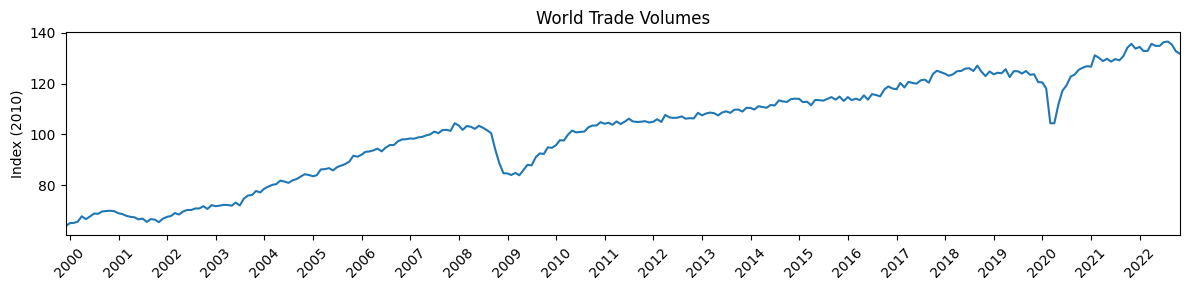

In [ ]:
data = get_data('world')['Finland']

fig, ax = plt.subplots(1,1)
ax.plot(data)
ax.set_title("World Trade Volumes")
ax.set_ylabel("Index (2010)")
ax.set_xlim(data.index[0], data.index[len(data)-1])
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(year_formatter) # formatter for major axis only
ax.tick_params(axis='x', labelrotation=45)
fig.set_size_inches(12,3)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Gradu/Figures/world_trade.png')

# Save Original Inflation Time Series

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/Original inflation/'
variable = 'inflation'

for country in countries:
    inflation_series = get_data(variable, input_path)[country]
    df = pd.DataFrame()
    df['Data'] = inflation_series
    df.to_csv(output_path + 'original_' + variable + '_' + country + '.csv')

# Stationarity for Monthly Data

In [ ]:
# Function to check if a time series is stationary using the ADF test
def is_stationary(time_series):
    adf_result = adfuller(time_series)
    p_value = adf_result[1]
    print(f"p-value: {p_value}")
    return p_value <= 0.05

In [ ]:
# log diff (percentage change)

def log_difference(input_arr):
    return np.log(input_arr).diff(1)

In [ ]:
# first difference
def first_difference(input_arr):
    return input_arr.diff(1)

In [ ]:
# one year difference
def year_difference(input_arr):
    return input_arr.diff(12)

In [ ]:
no_stationary = 0
no_non_stationary = 0

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/2_Stationary/'

for variable in all_variables:
  for country in countries:
        # Retrieve the time series data for the specific country and variable
        time_series = get_data(variable, input_path)[country]
        split_point = len(time_series)-12 # we are using training data only to test for stationarity

        print(f"Original Time Series ({variable}, {country}):")
        print(time_series.shape)

        # check if all elements are zero, if so, skip
        if np.all(time_series.eq(0)):
            print("All elements zero, no transformations will be done")
            print()
            df = pd.DataFrame()
            df['Data'] = time_series
            df.to_csv(output_path + variable + '_' + country + '.csv')

        else:
            time_series = time_series.fillna(time_series.mean())
            # Check if the original time series is already stationary
            if is_stationary(time_series[:split_point]):
                # Time series is already stationary, no transformation needed
                stationary_series = time_series
                no_stationary = no_stationary + 1
                transformation = "None"
            else:
                # Check if the time series contains negative or 0 values
                if np.any(time_series <= 0):
                    # Apply first difference for time series containing negative values
                    first_dif = first_difference(time_series)
                    first_dif = first_dif.fillna(first_dif.mean())

                    # Check if the series is stationary after first difference
                    if is_stationary(first_dif[:split_point]):
                        # Time series is stationary after first difference
                        stationary_series = first_dif
                        no_stationary = no_stationary + 1
                        transformation = "FD"
                    else:
                        first_dif_year_dif = year_difference(first_dif)
                        first_dif_year_dif = first_dif_year_dif.fillna(first_dif_year_dif.mean())

                        if is_stationary(first_dif_year_dif[:split_point]):
                            # Time series is stationary after first difference and 12 month difference
                            stationary_series = first_dif_year_dif
                            no_stationary = no_stationary + 1
                            transformation = "FDYD"
                        else:
                            # still not stationary after performing differencing twice
                            stationary_series = first_dif_year_dif
                            no_non_stationary = no_non_stationary + 1
                            transformation = "FDYD"
                            print(f"Still not stationary")
                else:
                    # Apply logarithmic difference for time series without negative values
                    log_dif = log_difference(time_series)
                    log_dif = log_dif.fillna(log_dif.mean())

                    # Check if the series is stationary after logarithmic difference
                    if is_stationary(log_dif[:split_point]):
                        # Time series is stationary after logarithmic difference
                        stationary_series = log_dif
                        no_stationary = no_stationary + 1
                        transformation = "PC"
                    else:
                        # Apply 12 month difference if logarithmic difference does not yield stationarity
                        log_dif_year_dif = year_difference(log_dif)
                        log_dif_year_dif = log_dif_year_dif.fillna(log_dif_year_dif.mean())

                        # Check if the series is stationary after first difference
                        if is_stationary(log_dif_year_dif[:split_point]):
                            # Time series is stationary after first difference
                            stationary_series = log_dif_year_dif
                            no_stationary = no_stationary + 1
                            transformation = "PCYD"
                        else:
                            # still not stationary after percentage change and 12 month diff
                            stationary_series = log_dif_year_dif
                            no_non_stationary = no_non_stationary + 1
                            transformation = "PCYD"
                            print(f"Still not stationary")

            # Print the transformation applied and the resulting stationary series
            print(f"Transformation Applied: {transformation}")
            print(f"Stationary Series ({variable}, {country}):")
            print()
            df = pd.DataFrame()
            df['Data'] = stationary_series
            df.to_csv(output_path + variable + '_' + country + '.csv')

Original Time Series (inflation, Belgium):
(276,)
p-value: 0.0037014340104977155
Transformation Applied: None
Stationary Series (inflation, Belgium):

Original Time Series (inflation, Denmark):
(276,)
p-value: 0.24784926781385247
p-value: 2.3148282793620562e-08
Transformation Applied: FD
Stationary Series (inflation, Denmark):

Original Time Series (inflation, Germany):
(276,)
p-value: 0.012430655700294007
Transformation Applied: None
Stationary Series (inflation, Germany):

Original Time Series (inflation, Spain):
(276,)
p-value: 0.19192498443955913
p-value: 5.493061850286509e-05
Transformation Applied: FD
Stationary Series (inflation, Spain):

Original Time Series (inflation, France):
(276,)
p-value: 0.1593788764765286
p-value: 2.0612171178932595e-10
Transformation Applied: FD
Stationary Series (inflation, France):

Original Time Series (inflation, Italy):
(276,)
p-value: 0.10959647881947232
p-value: 3.040726740655306e-05
Transformation Applied: FD
Stationary Series (inflation, Italy

# Cubic Spline Interpolation for Quarterly Data

In [ ]:
input_path2 = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/Excel preprocessed/'
output_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/Python preprocessed/'

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Define the quarterly variables and countries
quarterly_variables = ['gdp', 'house_prices', 'investment', 'domestic_demand']
countries = ['Belgium', 'Denmark', 'Germany', 'Spain', 'France', 'Italy', 'Netherlands', 'Austria', 'Poland', 'Finland', 'Sweden', 'United States']

# Iterate over each quarterly variable
for quarterly_variable in quarterly_variables:
    print(f"Variable: {quarterly_variable}")

    # Retrieve quarterly data for the variable
    quarterly_data = get_data(quarterly_variable, input_path2)

    # Create a DataFrame to store the interpolated monthly data
    df = pd.DataFrame(index=get_data('inflation', input_path2)['Finland'].index)

    # Retrieve monthly data for each country
    for country in countries:
        # Retrieve country-specific quarterly data
        q_data = quarterly_data[country]

        # Generate monthly time points for interpolation
        quarterly_time = np.arange(len(q_data)) + 1  # Assuming quarterly time points start from 1
        monthly_time = np.linspace(1, len(q_data), num=len(q_data) * 3)

        # Perform cubic spline interpolation
        cubic_interp = CubicSpline(quarterly_time, q_data)
        monthly_values = cubic_interp(monthly_time)

        # Store the interpolated monthly values in the DataFrame
        df[country] = monthly_values
        df.to_csv(output_path + quarterly_variable + '.csv')

    # Print the interpolated monthly data for the variable
    print(df)

Variable: gdp
             Belgium   Denmark   Germany     Spain    France     Italy  \
Date                                                                     
2000-01-01  4.800000  3.550000  3.400000  5.350000  4.370000  3.860000   
2000-02-01  4.735933  3.992023  4.011787  5.461383  4.677996  4.200817   
2000-03-01  4.492109  4.182129  4.271737  5.475147  4.800809  4.341800   
2000-04-01  4.138476  4.191293  4.243380  5.421699  4.772079  4.341164   
2000-05-01  3.744980  4.090492  3.990245  5.331448  4.625443  4.257123   
...              ...       ...       ...       ...       ...       ...   
2022-08-01  2.735319  4.228766  1.232542  6.135402  2.161242  3.333473   
2022-09-01  2.035978  3.941787  1.353046  4.821048  1.078062  2.462166   
2022-10-01  1.509415  3.454000  1.448758  3.618314  0.264992  1.763848   
2022-11-01  1.294475  2.696404  1.338226  2.872774  0.004736  1.386974   
2022-12-01  1.530000  1.600000  0.840000  2.930000  0.580000  1.480000   

            Netherlands

# Example of Cubic Spline Interpolation Result

(92,)
(276,)


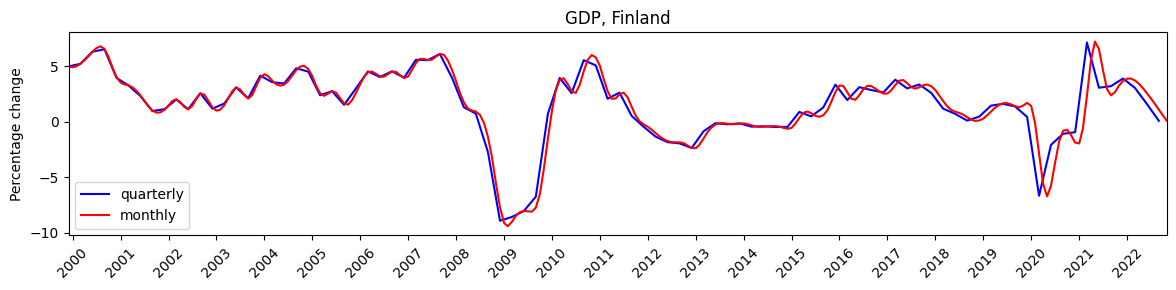

In [ ]:
input_path2 = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/Excel preprocessed/'

data2 = get_data('gdp', input_path2)['Finland']
print(data2.shape)

fig, ax = plt.subplots(1,1)
ax.plot(data2, color='blue')
ax.set_title("GDP, Finland")
ax.set_ylabel("Percentage change")
data2.index[0]

data = get_data('gdp')['Finland']
print(data.shape)
ax.plot(data, color='red')
ax.set_ylabel("Percentage change")
data.index[0]
ax.set_xlim(data.index[0], data.index[len(data)-1])
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(year_formatter) # formatter for major axis only
ax.tick_params(axis='x', labelrotation=45)
ax.legend(['quarterly', 'monthly'])
fig.set_size_inches(12,3)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Gradu/Figures/quarterly_monthly_gdp_finland.png')

# Stationarity for Previously Quarterly Data

In [ ]:
input_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/Python preprocessed/'
output_path = '/content/drive/MyDrive/Colab Notebooks/Gradu/Data/2_Stationary/'

no_stationary = 0
no_non_stationary = 0

In [ ]:
# Main loop to process time series for each country and variable

for variable in quarterly_variables:
  for country in countries:
        # Retrieve the time series data for the specific country and variable
        time_series = get_data(variable, input_path)[country]
        split_point = len(time_series)-12

        print(f"Original Time Series ({variable}, {country}):")
        print(time_series.shape)

        # check if all elements are zero, if so, skip
        if np.all(time_series.eq(0)):
            print("All elements zero, no transformations will be done")
            print()
            df = pd.DataFrame()
            df['Data'] = time_series
            df.to_csv(output_path + variable + '_' + country + '.csv')

        else:
            time_series = time_series.fillna(time_series.mean())
            # Check if the original time series is already stationary
            if is_stationary(time_series[:split_point]):
                # Time series is already stationary, no transformation needed
                stationary_series = time_series
                no_stationary = no_stationary + 1
                transformation = "None"
            else:
                # Check if the time series contains negative or 0 values
                if np.any(time_series <= 0):
                    # Apply first difference for time series containing negative values
                    first_dif = first_difference(time_series)
                    first_dif = first_dif.fillna(first_dif.mean())

                    # Check if the series is stationary after first difference
                    if is_stationary(first_dif[:split_point]):
                        # Time series is stationary after first difference
                        stationary_series = first_dif
                        no_stationary = no_stationary + 1
                        transformation = "FD"
                    else:
                        first_dif_year_dif = year_difference(first_dif)
                        first_dif_year_dif = first_dif_year_dif.fillna(first_dif_year_dif.mean())

                        if is_stationary(first_dif_year_dif[:split_point]):
                            # Time series is stationary after first difference and 12 month difference
                            stationary_series = first_dif_year_dif
                            no_stationary = no_stationary + 1
                            transformation = "FDYD"
                        else:
                            # still not stationary after performing differencing twice
                            stationary_series = first_dif_year_dif
                            no_non_stationary = no_non_stationary + 1
                            transformation = "FDYD"
                            print(f"Still not stationary")
                else:
                    # Apply logarithmic difference for time series without negative values
                    log_dif = log_difference(time_series)
                    log_dif = log_dif.fillna(log_dif.mean())

                    # Check if the series is stationary after logarithmic difference
                    if is_stationary(log_dif[:split_point]):
                        # Time series is stationary after logarithmic difference
                        stationary_series = log_dif
                        no_stationary = no_stationary + 1
                        transformation = "PC"
                    else:
                        # Apply 12 month difference if logarithmic difference does not yield stationarity
                        log_dif_year_dif = year_difference(log_dif)
                        log_dif_year_dif = log_dif_year_dif.fillna(log_dif_year_dif.mean())

                        # Check if the series is stationary after first difference
                        if is_stationary(log_dif_year_dif[:split_point]):
                            # Time series is stationary after first difference
                            stationary_series = log_dif_year_dif
                            no_stationary = no_stationary + 1
                            transformation = "PCYD"
                        else:
                            # still not stationary after percentage change and 12 month diff
                            stationary_series = log_dif_year_dif
                            no_non_stationary = no_non_stationary + 1
                            transformation = "PCYD"
                            print(f"Still not stationary")

            # Print the transformation applied and the resulting stationary series
            print(f"Transformation Applied: {transformation}")
            print(f"Stationary Series ({variable}, {country}):")
            print()
            df = pd.DataFrame()
            df['Data'] = stationary_series
            df.to_csv(output_path + variable + '_' + country + '.csv')

Original Time Series (gdp, Belgium):
(276,)
p-value: 0.005820772597960199
Transformation Applied: None
Stationary Series (gdp, Belgium):

Original Time Series (gdp, Denmark):
(276,)
p-value: 0.05320837976262054
p-value: 0.000892770508319682
Transformation Applied: FD
Stationary Series (gdp, Denmark):

Original Time Series (gdp, Germany):
(276,)
p-value: 4.842219847426534e-05
Transformation Applied: None
Stationary Series (gdp, Germany):

Original Time Series (gdp, Spain):
(276,)
p-value: 0.23947053807274543
p-value: 3.218874253674194e-05
Transformation Applied: FD
Stationary Series (gdp, Spain):

Original Time Series (gdp, France):
(276,)
p-value: 0.007840262059479793
Transformation Applied: None
Stationary Series (gdp, France):

Original Time Series (gdp, Italy):
(276,)
p-value: 0.004486857299950657
Transformation Applied: None
Stationary Series (gdp, Italy):

Original Time Series (gdp, Netherlands):
(276,)
p-value: 0.002456739846497244
Transformation Applied: None
Stationary Series (